In [21]:
using Revise
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
import ProgressMeter

In [22]:
import ReactiveMP.messageout

In [23]:
function sigmoid(y_,u_,θ)
    x = [y_;u_]'*θ
    1/(1+exp(-x))
end

sigmoid (generic function with 1 method)

In [24]:
function dummy_flow(h)
    h
end

function generate_data(n, order=1, var=1.0, theta=[1.0, 1.0])
    h = [0.0]
    y_lat = Float64[]
    y = [1.0]
    u = ones(n)
    for i in 1:n
        push!(h, sqrt(1.0)*randn())
        push!(y_lat, dummy_flow(h[end]))
        push!(y, sum(y_lat[end]) + sigmoid(y[end], u[i], theta) + sqrt(var)randn())
    end
    y_lat, h, y, u
end

generate_data (generic function with 4 methods)

In [55]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max(n, dim, model_flow::FlowModel, params, h_prior, w_prior, y_prev, u)
    # initialize variables
    h       = randomvar(n)
    y       = datavar(Float64, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    y_lat_3 = randomvar(n)
    
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end]
    
    sigmoid_out = [sigmoid(y_prev[i], u[i], params_f) for i in 1:n]

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    θ   ~ MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim))
    w   ~ GammaShapeRate(w_prior[1], w_prior[2]) where {q=MeanField()}
    
    # specify transformed latent value
    
    AR_meta = ARMeta(Multivariate, dim, ARsafe())
    
    h_prev = h_0
    
    ar_nodes = Vector{FactorNode}(undef, n)
    y_nodes = Vector{FactorNode}(undef, n)
    for t in 1:n

        # specify latent state
        ar_nodes[t], h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}

        y_lat_1[t] ~ Flow(h[t]) where { meta = Flow_meta }
        y_lat_2[t] ~ dot(y_lat_1[t], ones(dim))
        y_lat_3[t] ~ y_lat_2[t] + sigmoid_out[t]

        y_nodes[t], y[t] ~ NormalMeanPrecision(y_lat_3[t], w)
        
        h_prev = h[t]
    end

    # return variables
    return h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_nodes
end

nonlinear_max (generic function with 1 method)

In [56]:
function nonlinear_max_inference(observations::T,observations_prev::T, controls::T, model_flow::FlowModel, params; 
                                 h_prior=(zeros(dim), diageye(dim)), w_prior=(1.0, 1e3), dim=2, vmp_its = 10) where T<:Array{Float64,1}
    # fetch number of samples
    n = length(observations)

    # define model
    model, (h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_nodes) = nonlinear_max(n, dim, model_flow, params, h_prior, w_prior,
                                                                            observations_prev, controls,
                                                                            options = (limit_stack_depth = 500, ))
    
    h_post = getmarginals(h)
    
    h_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    w_buffer = nothing
    
    h_sub = subscribe!(h_post, (x) -> copyto!(h_buffer, x))
    w_sub = subscribe!(getmarginal(w), (x) -> w_buffer = x)
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))

    setmarginal!(w, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))
    
    for _ in 1:vmp_its
        setmarginal!(θ, MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))
        ReactiveMP.update!(y, observations)
    end
    
    # unsubscribe
    unsubscribe!(fe_sub)
    unsubscribe!(h_sub)
    unsubscribe!(w_sub)
    
    
    # return the marginal values
    return fe_buffer, h_buffer, w_buffer, y_out_buffer
    
end

nonlinear_max_inference (generic function with 1 method)

In [57]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_prediction(dim, model_flow::FlowModel, params, h_prior, w_prior, y_prev, u)
    # initialize variables
    y_pred       = datavar(Float64)
    
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end]

    sigmoid_pred = sigmoid(y_prev, u, params_f)

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    θ   ~ MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim))
    w   ~ GammaShapeRate(w_prior[1], w_prior[2]) where {q=MeanField()}
    
    # specify transformed latent value
    
    AR_meta = ARMeta(Multivariate, dim, ARsafe())
    
    h_prev = h_0
    # specify observations
    
    ar_node, h ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}
    
    y_lat_1 ~ Flow(h) where { meta = Flow_meta }
    
    y_lat_2 ~ dot(y_lat_1, ones(dim))
    
    y_lat_3 ~ y_lat_2 + sigmoid_pred

    y_node, y ~ NormalMeanPrecision(y_lat_3, w)
    
    y_pred ~ NormalMeanPrecision(y, 1e-12)
    
    return h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_node, y_pred
end

nonlinear_max_prediction (generic function with 2 methods)

In [58]:
function nonlinear_max_prediction(observation_prev::T, control::T, model_flow::FlowModel, params; 
                                  h_prior=(zeros(dim), diageye(dim)), w_prior=(1.0, 1e3), dim=2, vmp_its = 10) where T<:Float64

    # define model
    model, (h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_node, y_pred) = nonlinear_max_prediction(dim, model_flow, params, h_prior, w_prior,
                                                                                              observation_prev, control,
                                                                                              options = (limit_stack_depth = 500, ))
    
    h_buffer = nothing
    y_out_buffer = nothing
    w_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    y_pred_sub = subscribe!(getmarginal(y), (x) -> y_pred_buffer = x)
    w_sub = subscribe!(getmarginal(w), (x) -> w_buffer = x)

    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginal!(w, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))
    setmarginal!(y, NormalMeanPrecision(0.0, 1.0))
    
    for _ in 1:vmp_its
        setmarginal!(θ, MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, w_buffer, y_pred_buffer
    
end

nonlinear_max_prediction (generic function with 2 methods)

In [59]:
# specify flow model
dim = 2
model_flow = FlowModel(dim,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

In [60]:
y_lat, h_lat, y, u = generate_data(100, 1, 1.0, randn(2));
observations_prev = y[1:end-1]
observations, controls = y[2:end], u;

In [32]:
train_size = 80
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size]
X_test, Y_test, U_test = observations_prev[train_size+1:end], observations[train_size+1:end], controls[train_size+1:end];

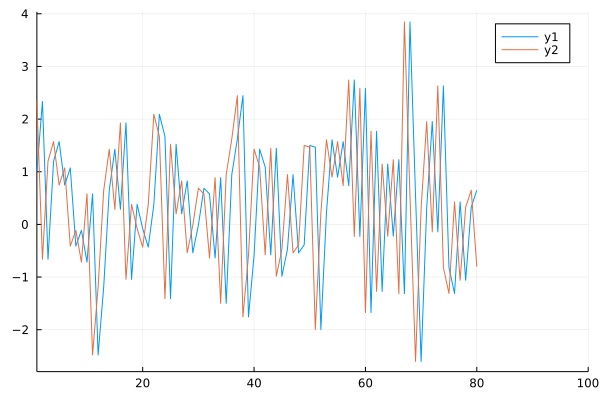

In [61]:
plot(X_train, xlims=(1, 100))
plot!(Y_train, xlims=(1, 100))

In [63]:
param_len = nr_params(model_flow)
fe, h, w, y_out = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, randn(param_len+2), dim=2, vmp_its=100);

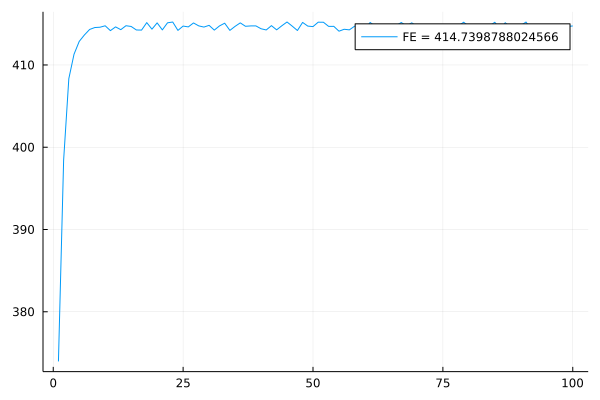

In [64]:
gr()
plot(fe, label="FE = $(fe[end])")

In [13]:
using ForwardDiff

In [69]:
function calculate_parameters(params, model_flow, Y_train, X_train, U_train)

    function f(params)
        fe, h, w, y_out = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, params, dim=2, vmp_its=50)
        return fe[end]
    end

    # @show f(randn(14))

    optimizer = Adam(params; λ=1e-1)

    ∇ = zeros(nr_params(model_flow)+2)

    ProgressMeter.@showprogress for it = 1:10000

        # backward pass
        ForwardDiff.gradient!(∇, f, optimizer.x)

        # gradient update
        ReactiveMP.update!(optimizer, ∇)

    end

    return f(optimizer.x), optimizer.x

end

calculate_parameters (generic function with 1 method)

In [70]:
f, inf_params = calculate_parameters(randn(nr_params(model_flow)+2), model_flow, Y_train, X_train, U_train)

(409.56950854418665, [5.48297194562909, -2.143382977287649, -8.270307707617274, 1.0546614118423832, 3.8843593455556773, 0.0019015105313457202, -2.932604320003063, 8.244416424499896, -1.5259223337056476, -0.7420648019211826, -5.988031397093848, 1.416331144783707, -35.90792092261172, 4.671708361325438])

In [76]:
inf_params = inf_params[2]

14-element Vector{Float64}:
   5.48297194562909
  -2.143382977287649
  -8.270307707617274
   1.0546614118423832
   3.8843593455556773
   0.0019015105313457202
  -2.932604320003063
   8.244416424499896
  -1.5259223337056476
  -0.7420648019211826
  -5.988031397093848
   1.416331144783707
 -35.90792092261172
   4.671708361325438

In [90]:
fe, h, w, y_out = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, inf_params, dim=2, vmp_its=100);

In [81]:
w

Marginal(GammaShapeRate{Float64}(a=81.0, b=2311.3902874695987))

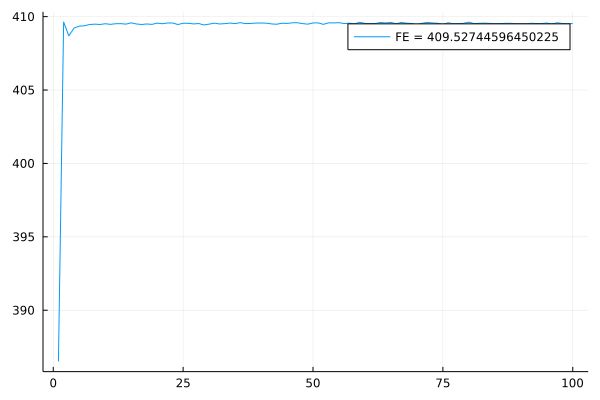

In [79]:
plot(fe, label="FE = $(fe[end])")

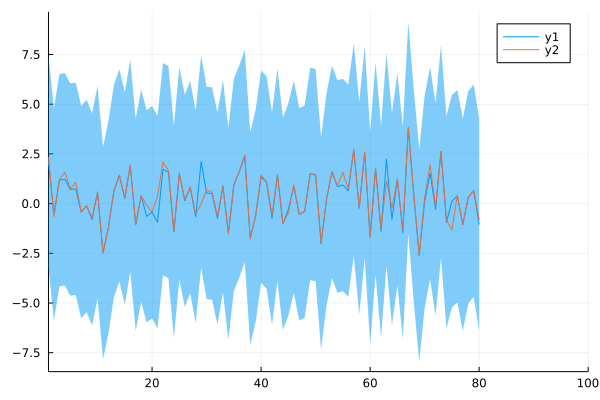

In [82]:
my, vy = mean.(y_out), cov.(y_out)
plot(my, ribbon=sqrt.(vy))
plot!(Y_train, xlims=(1, 100))

In [92]:
predictions = []
# for i in 1:length(X_test)
h_pred = (mean(h[end]), precision(h[end]))
w_pred = (shape(w), rate(w))
rw = []
for i in 1:length(X_test)
    fe, h_pred_, w_pred_, y_pred = nonlinear_max_prediction(X_test[i], 0.0, model_flow, inf_params, h_prior=h_pred, w_prior=w_pred, dim=2, vmp_its=100)
    push!(predictions, y_pred)
    h_pred = (mean(h_pred_), precision(h_pred_))
    w_pred = (shape(w_pred_), rate(w_pred_))
    push!(rw, [mean(h_pred_)[1], cov(h_pred_)[1]])
end

In [93]:
mx, vx = mean.(predictions), cov.(predictions)

([-8.581669038385442, -23.533292045167137, -11.250332920504475, -13.08462789530086, -12.638495652684606, -11.917900116637735, -12.790419058651281, -12.677047805538098, -12.69410264668198, -12.691448230943893, -12.691810121599744, -12.691726062097997, -12.691717302692577, -12.691701163599955, -11.907687968080964, -12.00712377960256, -12.776715205666811, -12.678311636668928, -11.90969853842018, -12.006791183198585], [28.56567594238033, 28.593119998403072, 28.614756158664935, 28.6378641986466, 28.659871003518035, 28.68099743688352, 28.702433415830622, 28.72351440913263, 28.74435067238703, 28.764963531158667, 28.785330021264183, 28.805514974980007, 28.825441450665455, 28.845203584614655, 28.864208866456337, 28.883133857689284, 28.902347878667875, 28.921235065858358, 28.939507154566506, 28.957680392898684])

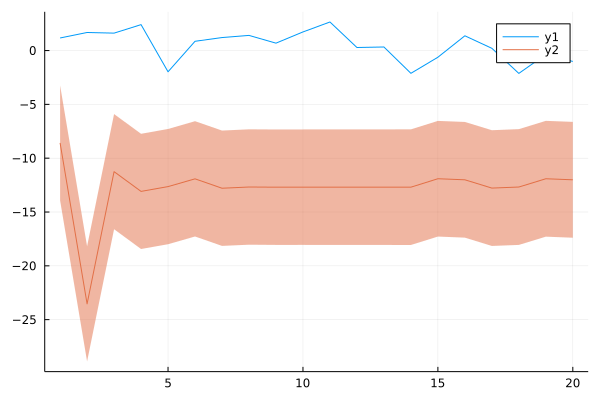

In [95]:
plot(Y_test)
plot!(mx, ribbon=sqrt.(vx))

In [36]:
mh, vh = mean.(h), cov.(h)
plot(first.(mh), ribbon=sqrt.(first.(vh)), xlims=(1, 100))

LoadError: MethodError: no method matching iterate(::Marginal{MvNormalWeightedMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}})
[0mClosest candidates are:
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m) at range.jl:664
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m, [91m::Int64[39m) at range.jl:664
[0m  iterate([91m::T[39m) where T<:Union{Base.KeySet{var"#s79", var"#s78"} where {var"#s79", var"#s78"<:Dict}, Base.ValueIterator{var"#s77"} where var"#s77"<:Dict} at dict.jl:693
[0m  ...

In [48]:
inv(mean(w))

13.557402496931145